In [1]:
TRAIN_DATA_DIR = 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1'
TRAIN_DATA_FILE = {
    'en': 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.data.v1.txt'
}
TRAIN_GOLD_FILE = {
    'en': 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.gold.v1.txt'
}

TEST_DATA_DIR = 'data/test_images_resized'
TEST_DATA_FILE = {
    'en': 'data/test.data.v1.1.gold/en.test.data.v1.1.txt',
    'it': 'data/test.data.v1.1.gold/it.test.data.v1.1.txt',
    'fa': 'data/test.data.v1.1.gold/fa.test.data.txt'
}
TEST_GOLD_FILE = {
    'en': 'data/test.data.v1.1.gold/en.test.gold.v1.1.txt',
    'it': 'data/test.data.v1.1.gold/it.test.gold.v1.1.txt',
    'fa': 'data/test.data.v1.1.gold/fa.test.gold.txt'
}

BATCH_SIZE = 64

In [2]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Set the random seed for reproducibility
torch.manual_seed(42)
# Enable TPU cores
torch.set_float32_matmul_precision('medium')

In [3]:
# Load TensorBoard extension
%load_ext tensorboard

In [4]:
# Import modules
from src.dataset import dataset
from src.utils import utils
from src.model import clip, clip_moco

# Reload all modules
import importlib
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(clip)
importlib.reload(clip_moco)

<module 'src.model.clip_moco' from '/home/luigi/Documents/HotNLP/homework3/src/model/clip_moco.py'>

## Dataset

In [5]:
# utils.resize_images(TRAIN_DATA_DIR)
# utils.resize_images(TEST_DATA_DIR)

In [6]:
# Define a transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)), # For example, resize to 224x224 for CNNs
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert all images to RGB
    transforms.ToTensor(),
])

# Create the train and test datasets
train_WSD_dataset = dataset.VisualWSDDatasetCLIP(
    data_dir=TRAIN_DATA_DIR,
    data_file=TRAIN_DATA_FILE,
    gold_file=TRAIN_GOLD_FILE,
    transform=transform,
    language='en')
test_WSD_dataset = dataset.VisualWSDDatasetCLIP(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE,
    transform=transform,
    language='en')

Building VisualWSDDataset:   0%|          | 0/12869 [00:00<?, ?it/s]

Building VisualWSDDataset:   0%|          | 0/463 [00:00<?, ?it/s]

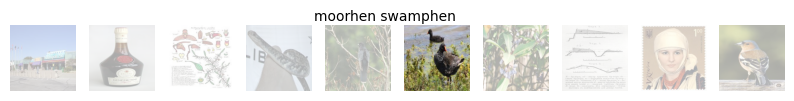

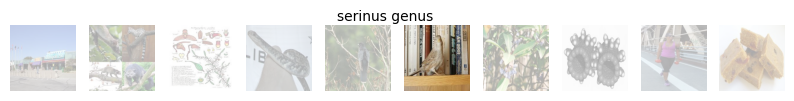

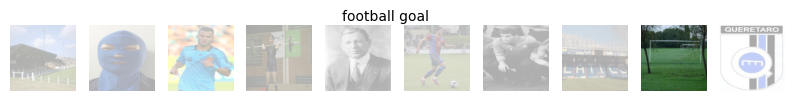

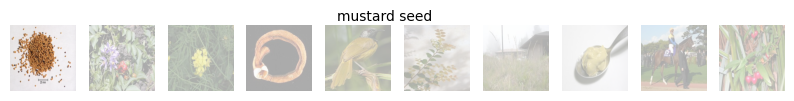

In [7]:
utils.display_samples(train_WSD_dataset, 2)
utils.display_samples(test_WSD_dataset, 2)

In [8]:
# Define parameters
split_ratio = 0.8

# Calculate split sizes
calculate_split_sizes = lambda dataset_size, split_ratio: (int(split_ratio * dataset_size), dataset_size - int(split_ratio * dataset_size))

# Splitting the dataset
train_size, eval_size = calculate_split_sizes(len(train_WSD_dataset), split_ratio)
train_dataset, eval_dataset = random_split(train_WSD_dataset, [train_size, eval_size])

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_WSD_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# CLIP

## Standard CLIP

In [9]:
# Initialize model
clip_model = clip.ClipModel()

/home/luigi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
# Training the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(clip_model, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | clip_model  | CLIPModel | 151 M 
1 | vision_proj | Linear    | 65.7 K
2 | text_proj   | Linear    | 65.7 K
------------------------------------------
131 K     Trainable params
151 M     Non-trainable params
151 M     Total params
605.635   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
# Save model weights
trainer.save_checkpoint("weights/modelv1_3.ckpt")
# Load model weights
pretrained_model = model.ClipModel.load_from_checkpoint(checkpoint_path="weights/modelv1_2.ckpt")

In [14]:
trainer = pl.Trainer()
trainer.test(model=clip_model, dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_h_at_1          0.20734341442584991
        test_mrr            0.3063766360282898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_h_at_1': 0.20734341442584991, 'test_mrr': 0.3063766360282898}]

## MOCO Clip

In [9]:
# Initialize model
clip_moco_model = clip_moco.ClipMocoModel()

/home/luigi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [13]:
# Training the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(clip_moco_model, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | clip_model    | CLIPModel | 151 M 
1 | vision_proj   | Linear    | 65.7 K
2 | text_proj     | Linear    | 65.7 K
3 | clip_model_m  | CLIPModel | 151 M 
4 | vision_proj_m | Linear    | 65.7 K
5 | text_proj_m   | Linear    | 65.7 K
--------------------------------------------
262 K     Trainable params
302 M     Non-trainable params
302 M     Total params
1,211.269 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reusing TensorBoard on port 6006 (pid 10529), started 1:33:17 ago. (Use '!kill 10529' to kill it.)

In [12]:
trainer = pl.Trainer()
trainer.test(model=clip_moco_model, dataloaders=test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_h_at_1         0.023758098483085632
        test_mrr            0.0993516817688942
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_h_at_1': 0.023758098483085632, 'test_mrr': 0.0993516817688942}]